# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SVMSMOTE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
import random

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
azdias = azdias[list(set(customers.columns).intersection(azdias.columns))]
customers = customers[list(set(customers.columns).intersection(azdias.columns))]

azdias = azdias.replace(-1, np.NaN)

In [6]:
azdias.isna().mean()[azdias.isna().mean()>0.8].sort_values(ascending=False)

ALTER_KIND4    0.998648
ALTER_KIND3    0.993077
ALTER_KIND2    0.966900
ALTER_KIND1    0.909048
dtype: float64

In [7]:
azdias["ALTER_KIND1"].value_counts()

18.0    6703
17.0    6394
8.0     6343
7.0     6249
16.0    6124
15.0    6008
14.0    5992
9.0     5846
13.0    5713
10.0    5678
12.0    5576
11.0    5506
6.0     4875
5.0     1501
4.0     1084
3.0     1063
2.0      403
Name: ALTER_KIND1, dtype: int64

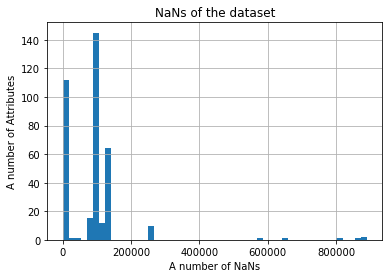

In [8]:
# How much data is missing in each row of the dataset
nans = azdias.isnull().sum()
nans.hist(bins=50)
plt.title('NaNs of the dataset')
plt.xlabel('A number of NaNs')
plt.ylabel('A number of Attributes')
plt.show()

In [9]:
df = azdias[list(nans[nans < 200000].index)]

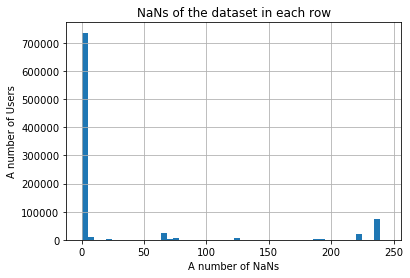

In [10]:
# How much data is missing in each row of the dataset
nan_in_each_row = df.isnull().sum(axis=1)
nan_in_each_row.hist(bins=50)
plt.title('NaNs of the dataset in each row')
plt.xlabel('A number of NaNs')
plt.ylabel('A number of Users')
plt.show()

In [11]:
# divide the data into two subsets based on the number of missing values in each row.
df_inlier = df[nan_in_each_row < 50]
df_outlier = df[nan_in_each_row >= 50]

In [12]:
df_inlier.head()

,CJT_KATALOGNUTZER,FINANZ_UNAUFFAELLIGER,D19_BEKLEIDUNG_GEH,ANZ_TITEL,KBA05_MODTEMP,PLZ8_ANTG1,FINANZ_VORSORGER,D19_KONSUMTYP_MAX,SEMIO_KRIT,D19_SONSTIGE,...,ORTSGR_KLS9,KBA13_ALTERHALTER_45,D19_VERSI_ONLINE_DATUM,KBA13_MERCEDES,TITEL_KZ,KBA13_HALTER_55,D19_SCHUHE,PLZ8_GBZ,D19_BANKEN_REST,CJT_TYP_4
1,1.0,4,0,0.0,1.0,2.0,2,9,4,0,...,5.0,2.0,10,4.0,0.0,3.0,0,4.0,0,3.0
2,2.0,3,0,0.0,4.0,3.0,1,8,7,6,...,5.0,2.0,10,4.0,0.0,3.0,0,4.0,0,3.0
3,3.0,1,0,0.0,3.0,2.0,5,8,4,6,...,3.0,3.0,10,3.0,0.0,5.0,0,4.0,0,4.0
4,3.0,3,6,0.0,3.0,2.0,4,1,3,4,...,6.0,3.0,10,3.0,0.0,4.0,1,3.0,6,4.0
5,5.0,2,0,0.0,3.0,2.0,5,1,4,6,...,3.0,4.0,10,3.0,0.0,4.0,0,5.0,0,5.0


In [13]:
df_outlier.head()

,CJT_KATALOGNUTZER,FINANZ_UNAUFFAELLIGER,D19_BEKLEIDUNG_GEH,ANZ_TITEL,KBA05_MODTEMP,PLZ8_ANTG1,FINANZ_VORSORGER,D19_KONSUMTYP_MAX,SEMIO_KRIT,D19_SONSTIGE,...,ORTSGR_KLS9,KBA13_ALTERHALTER_45,D19_VERSI_ONLINE_DATUM,KBA13_MERCEDES,TITEL_KZ,KBA13_HALTER_55,D19_SCHUHE,PLZ8_GBZ,D19_BANKEN_REST,CJT_TYP_4
0,5.0,5,0,NaN,NaN,NaN,3,9,7,0,...,NaN,NaN,10,NaN,NaN,NaN,0,NaN,0,5.0
11,5.0,5,0,NaN,NaN,NaN,3,9,7,0,...,NaN,NaN,10,NaN,NaN,NaN,0,NaN,0,5.0
12,4.0,4,0,0.0,5.0,3.0,4,3,5,6,...,6.0,3.0,10,5.0,0.0,3.0,3,5.0,0,2.0
13,1.0,5,0,0.0,5.0,2.0,3,2,7,0,...,6.0,2.0,10,3.0,0.0,4.0,0,3.0,6,2.0
14,5.0,5,0,NaN,NaN,NaN,3,9,7,0,...,NaN,NaN,10,NaN,NaN,NaN,0,NaN,0,5.0


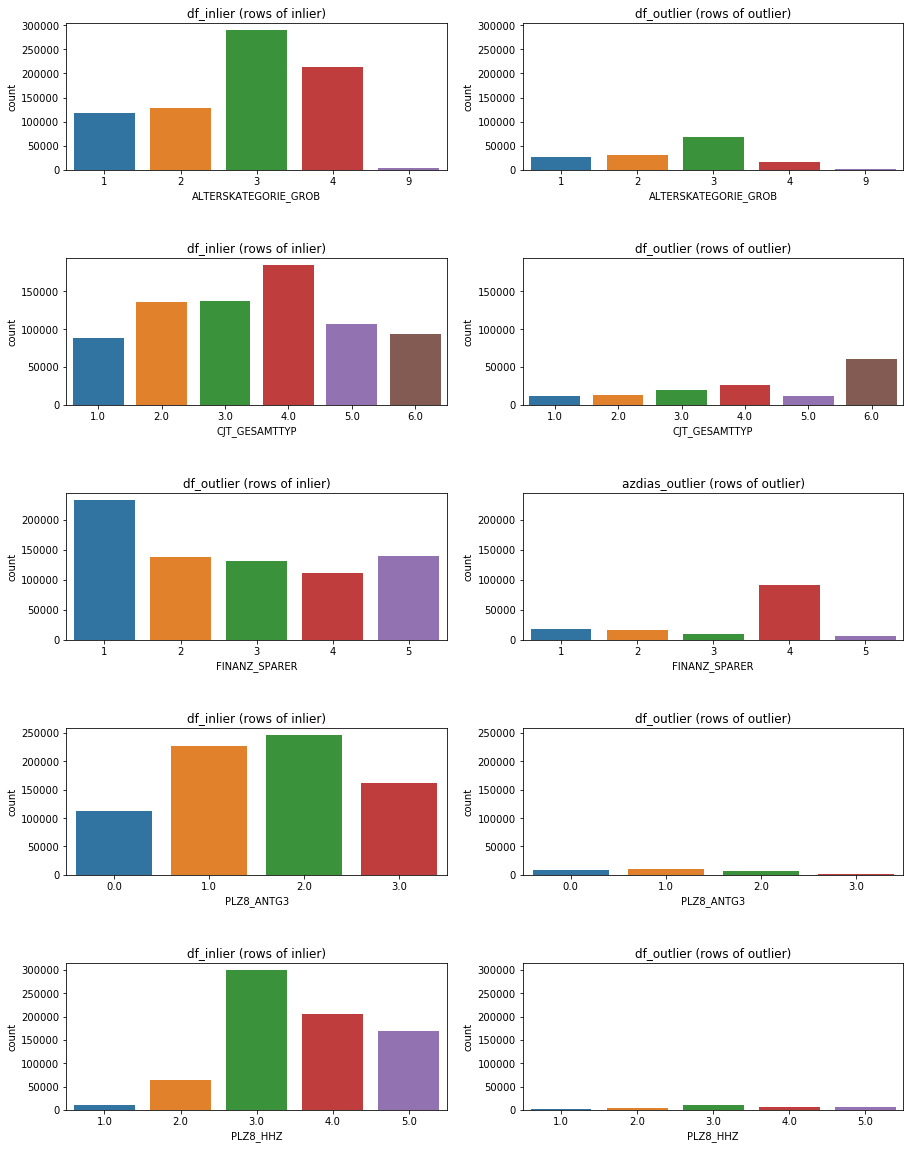

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.6)

# ALTERSKATEGORIE_GROB
ax1 = plt.subplot(5, 2, 1)
plt.title('df_inlier (rows of inlier)')
sns.countplot(x=df_inlier['ALTERSKATEGORIE_GROB'])
ax2 = plt.subplot(5, 2, 2, sharey=ax1)
plt.title('df_outlier (rows of outlier)')
sns.countplot(x=df_outlier['ALTERSKATEGORIE_GROB'])

# CJT_GESAMTTYP
ax1 = plt.subplot(5, 2, 3)
plt.title('df_inlier (rows of inlier)')
sns.countplot(x=df_inlier['CJT_GESAMTTYP'])
ax2 = plt.subplot(5, 2, 4, sharey=ax1)
plt.title('df_outlier (rows of outlier)')
sns.countplot(x=df_outlier['CJT_GESAMTTYP'])

# FINANZ_SPARER
ax1 = plt.subplot(5, 2, 5)
plt.title('df_outlier (rows of inlier)')
sns.countplot(x=df_inlier['FINANZ_SPARER'])
ax2 = plt.subplot(5, 2, 6, sharey=ax1)
plt.title('azdias_outlier (rows of outlier)')
sns.countplot(x=df_outlier['FINANZ_SPARER'])

# PLZ8_ANTG3
ax1 = plt.subplot(5, 2, 7)
plt.title('df_inlier (rows of inlier)')
sns.countplot(x=df_inlier['PLZ8_ANTG3'])
ax2 = plt.subplot(5, 2, 8, sharey=ax1)
plt.title('df_outlier (rows of outlier)')
sns.countplot(x=df_outlier['PLZ8_ANTG3'])

# PLZ8_HHZ
ax1 = plt.subplot(5, 2, 9)
plt.title('df_inlier (rows of inlier)')
sns.countplot(x=df_inlier['PLZ8_HHZ'])
ax2 = plt.subplot(5, 2, 10, sharey=ax1)
plt.title('df_outlier (rows of outlier)')
sns.countplot(x=df_outlier['PLZ8_HHZ'])

plt.show()

Users that have a small/large number of NaNs should be removed, because there are some attribute with a quantitatively different distribution of value to capture the characteristics of the dataset properly.

In [15]:
df = df_inlier

In [16]:
df.select_dtypes("object").head()

,CAMEO_DEUG_2015,CAMEO_DEU_2015,OST_WEST_KZ,CAMEO_INTL_2015,EINGEFUEGT_AM
1,8,8A,W,51,1992-02-10 00:00:00
2,4,4C,W,24,1992-02-12 00:00:00
3,2,2A,W,12,1997-04-21 00:00:00
4,6,6B,W,43,1992-02-12 00:00:00
5,8,8C,W,54,1992-02-12 00:00:00


In [17]:
df= df.drop(["EINGEFUEGT_AM"],axis =1)

In [18]:
df['CAMEO_DEUG_2015'].value_counts()

8      76227
9      60866
6      58851
4      55529
8.0    55162
2      44594
3      44523
9.0    44375
7      43192
6.0    42922
4.0    40463
3.0    32359
2.0    32322
7.0    31577
5      29369
5.0    21002
1      19936
1.0    14457
X        289
Name: CAMEO_DEUG_2015, dtype: int64

In [19]:
df['CAMEO_INTL_2015'].value_counts()

51      75961
51.0    54965
41      51362
24      49388
41.0    37337
24.0    35723
14      34151
43      31376
54      25574
14.0    24592
43.0    22992
25      21597
54.0    18717
22      17454
25.0    15932
45      14710
13      14087
55      13167
22.0    12857
52      11639
23      11613
45.0    10568
13.0    10262
34      10250
55.0     9682
31       9419
15       9415
52.0     8564
23.0     8310
44       8178
34.0     7430
12       6877
15.0     6869
31.0     6868
44.0     6028
35       5840
32       5693
33       5336
12.0     5056
35.0     4101
32.0     4030
33.0     3756
XX        289
Name: CAMEO_INTL_2015, dtype: int64

In [20]:
df = df[df['CAMEO_DEUG_2015'] != "X"]
df = df[df['CAMEO_INTL_2015']!="XX"]

In [21]:
df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype("float64")
df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype("float64")

In [22]:
df.select_dtypes("object").head()

,CAMEO_DEU_2015,OST_WEST_KZ
1,8A,W
2,4C,W
3,2A,W
4,6B,W
5,8C,W


In [23]:
df["OST_WEST_KZ"].value_counts()

W    591449
O    159593
Name: OST_WEST_KZ, dtype: int64

In [2]:
def df_clean(df):
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({'W': 1,'O': 2,})

    # An iterval-type for decade, 40th -> 1, 50th -> 2, 60th -> 3, 70th -> 4, 80th -> 5, 90th -> 6
    df['PRAEGENDE_JUGENDJAHR_decade'] =  df['PRAEGENDE_JUGENDJAHRE'].replace({
        1: '1',2: '1',3: '2',4: '2',5: '3',6: '3',7: '3',8: '4',9: '4',10: '5',11: '5',12: '5',13: '5',14: '6',15: '6'})

    # Movement, Avantgarde -> 1.0, Mainstream -> 2.0
    df['PRAEGENDE_JUGENDJAHR_movements'] = df['PRAEGENDE_JUGENDJAHRE'].replace({
        1: 2,2: 1,3: 2,4: 1,5: 2,6: 1,7: 1,8: 2,9: 1,10: 2,11: 1,12: 2,13: 1,14: 2,15: 1})

    # Wealth, Wealthy Households -> 5.0, Prosperous Households -> 4.0, Comfortable Households -> 3.0, Less Affluent Households -> 2.0, Poorer Households -> 1.0
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].replace({
        11: 5,12: 5,13: 5,14: 5,15: 5,21: 4,22: 4,23: 4,24: 4,25: 4,31: 3,32: 3,33: 3,34: 3,35: 3,41: 2,42: 2,43: 2,44: 2,
        45: 2,51: 1,52: 1,53: 1,54: 1,55: 1})

    # Life stage, Pre-Family Couples & Singles -> 1.0, Young Couples With Children -> 2.0, Families With School Age Children -> 3.0, Older Families &  Mature Couples -> 4.0, Elders In Retirement -> 5.0
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].replace({
        11: '1',12: '2',13: '3',14: '4',15: '5',21: '1',22: '2',23: '3',24: '4',25: '5',31: '1',32: '2',33: '3',34: '4',35: '5',
        41: '1',42: '2',43: '3',44: '4',45: '5',51: '1',52: '2',53: '3',54: '4',55: '5'})

    # Rural, Rural -> 1.0, Not Rural -> 2.0
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].replace({
        0: 2,1: 2,2: 2,3: 2,4: 2,5: 2,7: 1,8: 1})

    # Neighborhood quality, Very good neighborhood -> 6.0, Good neighborhood -> 5.0, Average neighborhood -> 4.0, Poor neighborhood -> 3.0, Very poor neighborhood -> 2.0, Unknown -> 1.0
    df['WOHNLAGE_neighborhood'] = df['WOHNLAGE'].replace({
        0: 1,1: 6,2: 5,3: 4,4: 3,5: 2,7: 1,8: 1})
    
    df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','WOHNLAGE'],axis = 1)
    
    return df

In [25]:
for col in df.select_dtypes(include="object").columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)

In [26]:
df.shape

(751042, 391)

In [27]:
df_imputed = df.fillna(-1)

In [28]:
minmax_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(minmax_scaler.fit_transform(df_imputed))
df_scaled.columns = df_imputed.columns
df_scaled.head()

,CJT_KATALOGNUTZER,FINANZ_UNAUFFAELLIGER,D19_BEKLEIDUNG_GEH,ANZ_TITEL,KBA05_MODTEMP,PLZ8_ANTG1,FINANZ_VORSORGER,D19_KONSUMTYP_MAX,SEMIO_KRIT,D19_SONSTIGE,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W
0,0.333333,0.75,0.000000,0.0,0.0,0.6,0.25,1.000,0.500000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.500000,0.50,0.000000,0.0,0.6,0.8,0.00,0.875,1.000000,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.666667,0.00,0.000000,0.0,0.4,0.6,1.00,0.875,0.500000,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.666667,0.50,0.857143,0.0,0.4,0.6,0.75,0.000,0.333333,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.000000,0.25,0.000000,0.0,0.4,0.6,1.00,0.000,0.500000,0.857143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
# Check NaNs
df_scaled.isna().sum().sum()

0

In [30]:
#df_scaled.to_csv("data_1.csv",index=False)

In [31]:
df_scaled = pd.read_csv("data_1.csv", sep=',')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [32]:
nans = customers.isnull().sum()
df = customers[list(nans[nans < 200000].index)]
nan_in_each_row = df.isnull().sum(axis=1)
df = df[nan_in_each_row < 50]
df_c_outlier = df[nan_in_each_row >= 50]
df= df.drop(["EINGEFUEGT_AM"],axis =1)
df = df[df['CAMEO_DEUG_2015'] != "X"]
df = df[df['CAMEO_INTL_2015']!="XX"]
df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype("float64")
df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype("float64")
df = df_clean(df)
df = df[list(set(df_scaled.columns).intersection(df.columns))]
df_scaled = df_scaled[list(set(df_scaled.columns).intersection(df.columns))]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [33]:
for col in df.select_dtypes(include="object").columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)

In [34]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

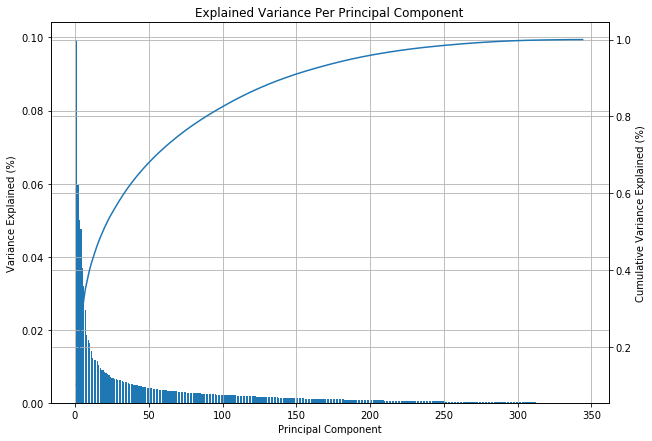

In [35]:
# Investigate the variance accounted for by each principal component.

num_components = len(pca.explained_variance_ratio_)
indx = np.arange(num_components) + 1 # start with 1
variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))

cumulative_variance_ratio = np.cumsum(variance_ratio)

plt.bar(indx, variance_ratio)
plt.ylabel("Variance Explained (%)")
plt.xlabel("Principal Component")
plt.grid(True)
plt.twinx()

plt.plot(indx, cumulative_variance_ratio)
plt.ylabel("Cumulative Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')
plt.grid(True)

plt.show()

In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=100)
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
def plot_weights(df, pca, n_comp):
    features, weights = zip(*sorted(zip(df.columns.tolist(), pca.components_[n_comp].tolist()), key=lambda x:x[1]))

    df_tmp = pd.DataFrame({'Features': features, 'Weights': weights})
    
    df_tmp.plot.barh(x='Features', y='Weights', figsize=(6, 50), grid=True)
    plt.ylabel('Features')
    plt.xlabel('Weights')
    plt.title('Weights for the ' + str(n_comp+1) + ' th component')

    plt.show()
    return features[0:3]+features[-3:]

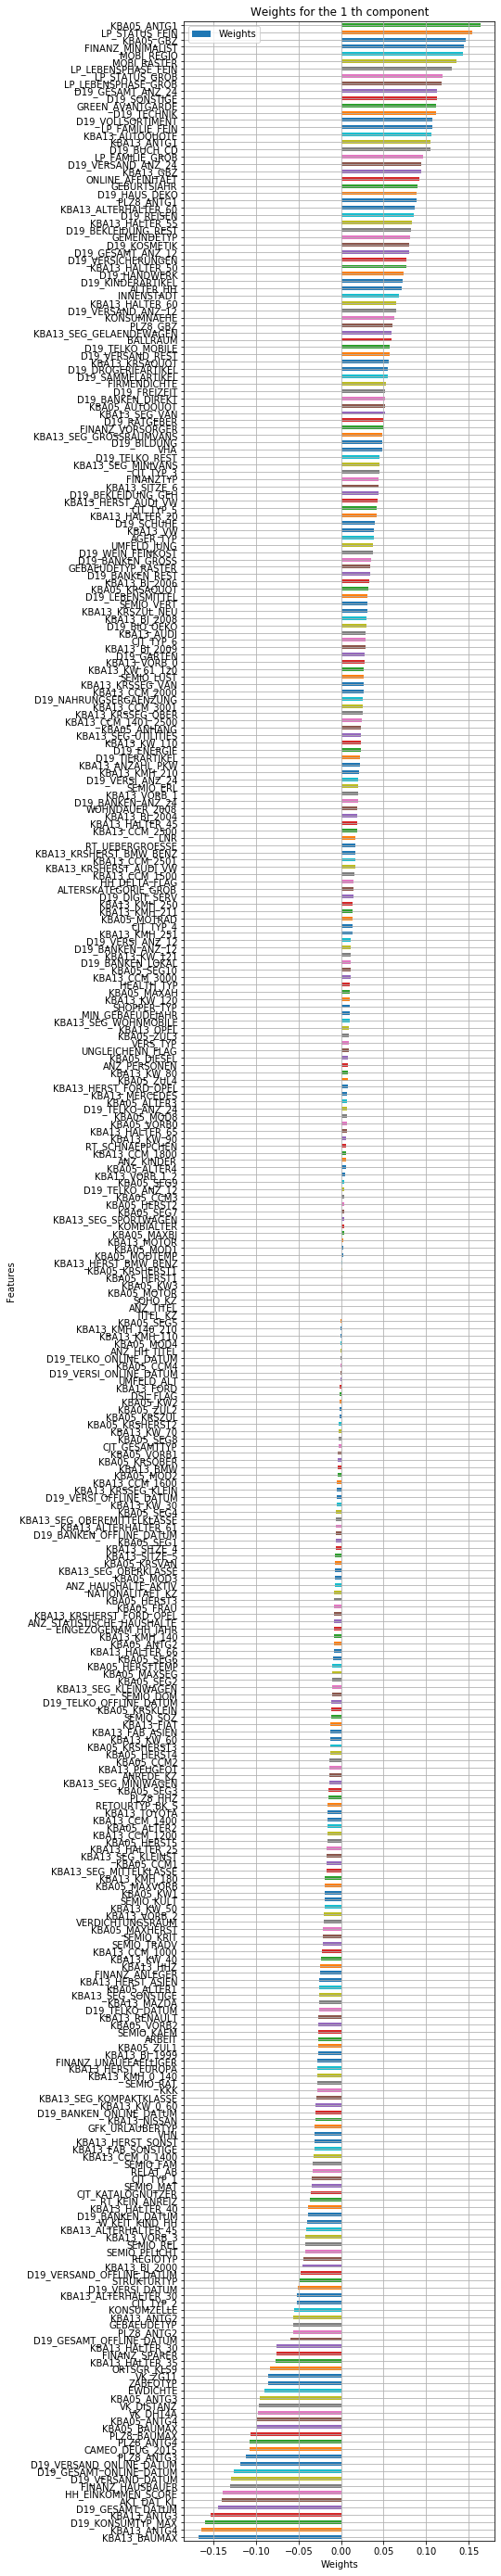

('KBA13_BAUMAX',
 'KBA13_ANTG4',
 'D19_KONSUMTYP_MAX',
 'KBA05_GBZ',
 'LP_STATUS_FEIN',
 'KBA05_ANTG1')

In [38]:
plot_weights(df_scaled, pca, 0)

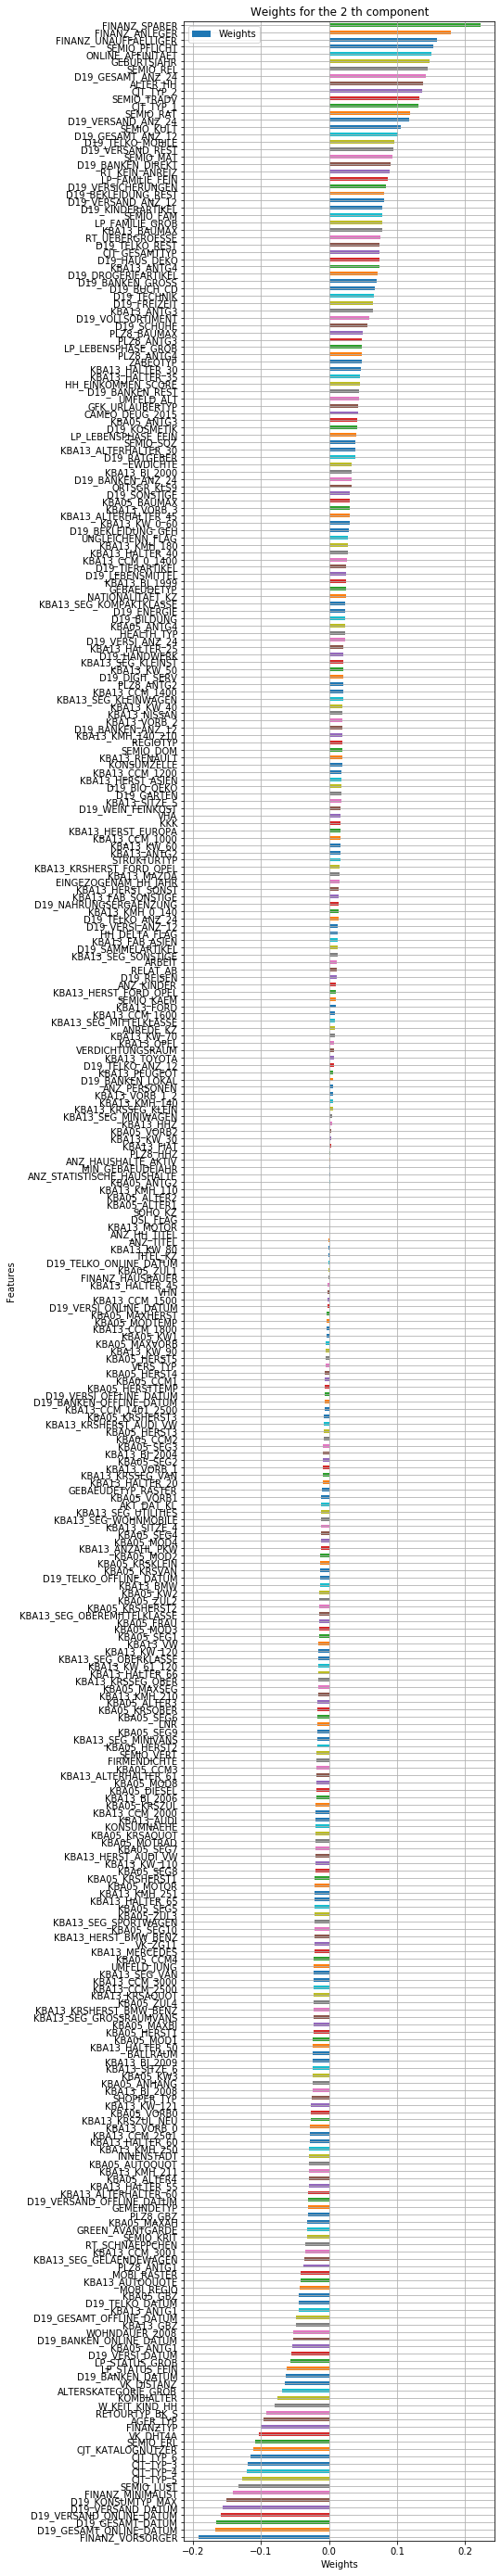

('FINANZ_VORSORGER',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER')

In [39]:
plot_weights(df_scaled, pca, 1)

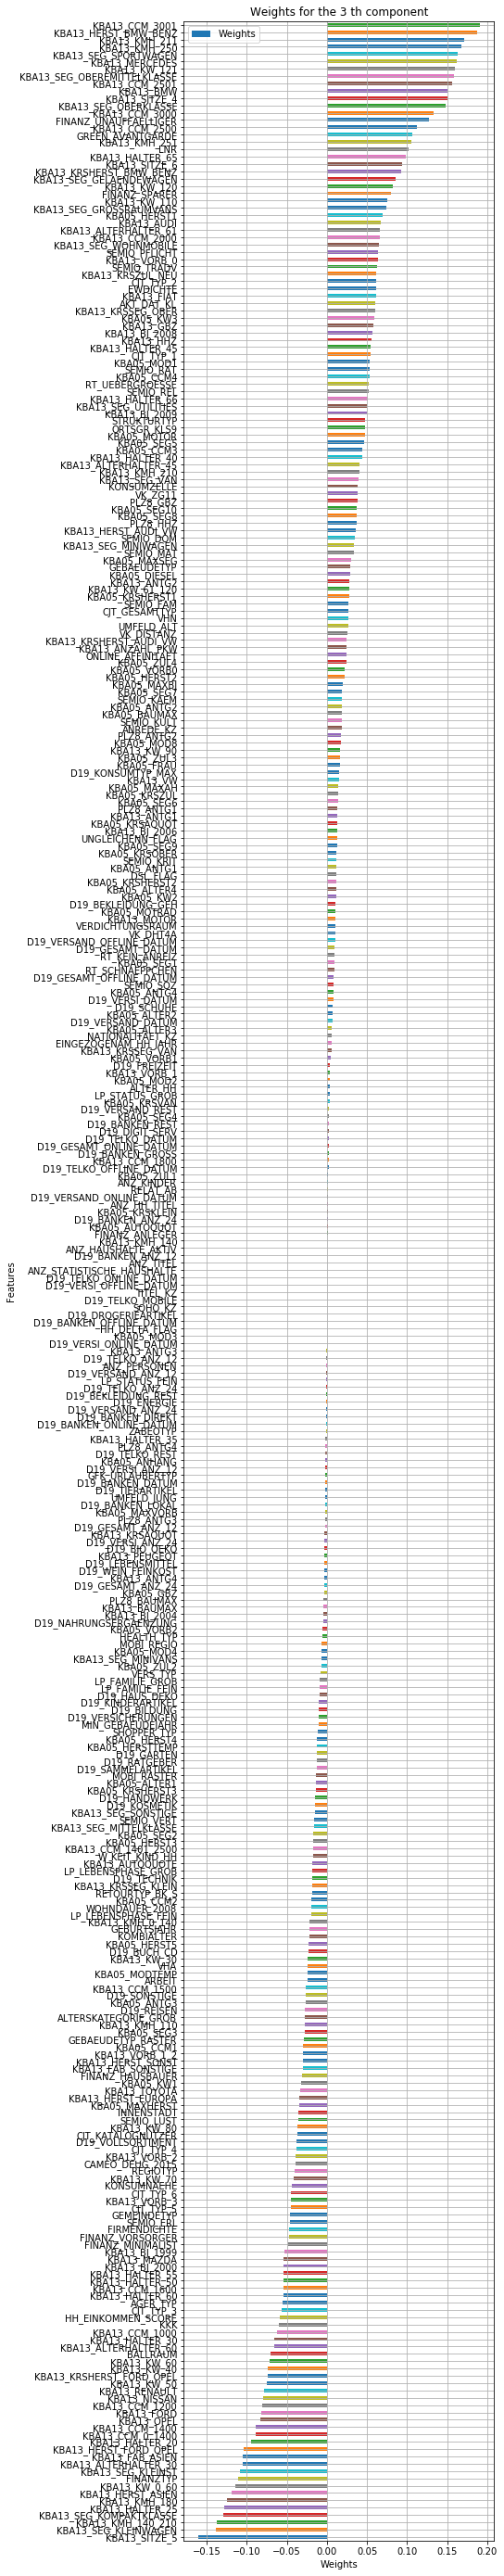

('KBA13_SITZE_5',
 'KBA13_SEG_KLEINWAGEN',
 'KBA13_KMH_140_210',
 'KBA13_KMH_211',
 'KBA13_HERST_BMW_BENZ',
 'KBA13_CCM_3001')

In [40]:
plot_weights(df_scaled, pca, 2)

In [41]:
# Over a number of different cluster counts...
models = []
for i in range(1, 10):
    models.append(KMeans(n_clusters=i))

# run k-means clustering on the data and...
X = pca.transform(df_scaled)
for model in models:
    model.fit(X)

# compute the average within-cluster distances.
scores = []
for model in models:
    scores.append(np.abs(model.score(X)))

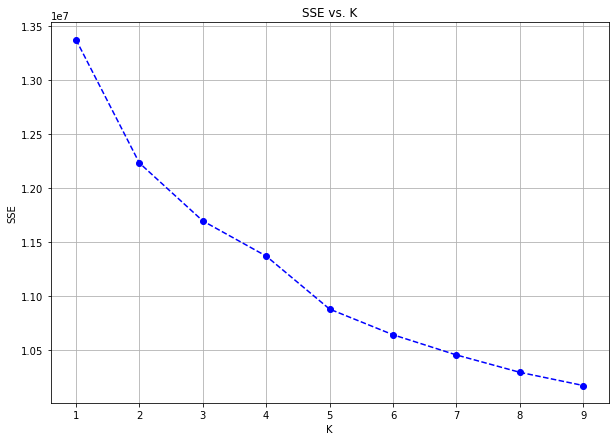

In [42]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 7))
plt.plot(range(1, 10), scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.grid(True)
plt.show()

In [43]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model= KMeans(n_clusters=4)
model_population = model.fit(X)

In [44]:
df_imputed = df.fillna(-1)

In [45]:
df_imputed.shape

(135030, 344)

In [46]:
minmax_scaler = MinMaxScaler()
df_c_scaled = pd.DataFrame(minmax_scaler.fit_transform(df_imputed))
df_c_scaled.columns = df_imputed.columns
df_c_scaled.head()

,CJT_KATALOGNUTZER,FINANZ_UNAUFFAELLIGER,D19_BEKLEIDUNG_GEH,ANZ_TITEL,KBA05_MODTEMP,PLZ8_ANTG1,FINANZ_VORSORGER,D19_KONSUMTYP_MAX,SEMIO_KRIT,D19_SONSTIGE,...,ORTSGR_KLS9,KBA13_ALTERHALTER_45,D19_VERSI_ONLINE_DATUM,KBA13_MERCEDES,TITEL_KZ,KBA13_HALTER_55,D19_SCHUHE,PLZ8_GBZ,D19_BANKEN_REST,CJT_TYP_4
0,0.833333,0.25,0.0,0.0,0.2,0.8,1.00,0.125,0.333333,0.857143,...,0.3,0.25,1.0,0.50,0.0,1.00,0.000000,1.000000,0.0,1.000000
1,1.000000,0.75,0.0,0.0,0.4,0.6,1.00,0.125,1.000000,0.857143,...,0.6,0.50,1.0,0.50,0.0,0.50,0.000000,0.500000,0.0,1.000000
2,1.000000,0.00,0.0,0.0,0.6,0.8,1.00,0.125,0.333333,0.000000,...,0.4,0.75,1.0,0.75,0.0,0.50,0.000000,0.833333,0.0,1.000000
3,0.833333,1.00,0.0,0.0,0.6,0.6,0.75,0.375,0.333333,0.857143,...,0.6,0.50,1.0,0.50,0.0,0.50,0.428571,0.666667,0.0,0.833333
4,0.666667,0.25,0.0,0.0,0.0,0.6,1.00,0.125,0.666667,0.857143,...,0.8,1.00,1.0,1.00,0.0,0.25,0.000000,1.000000,0.0,1.000000


In [47]:
#df_c_scaled.to_csv("data_customers_1.csv",index=False)

In [48]:
#df_c_scaled = pd.read_csv("data_customers_1.csv", sep=',')

In [49]:
df_scaled.shape

(751042, 344)

In [50]:
df_c_scaled.shape

(135030, 344)

In [51]:
pca.transform(df_c_scaled)

array([[ 1.97362065, -1.81801645,  0.61525413, ...,  0.05407197,
         0.51249631, -0.05023277],
       [-0.36481299, -1.4747341 ,  0.12916078, ..., -0.06927006,
         0.01622991,  0.29190228],
       [ 1.29906433, -1.30590128, -0.30042329, ...,  0.20278108,
        -0.29697455,  0.29514118],
       ...,
       [ 1.19406312, -1.41460963, -0.27013466, ...,  0.16261693,
        -0.30791678, -0.0928925 ],
       [ 0.78910468,  0.21387072, -0.43248243, ...,  0.13015867,
        -0.33011192, -0.02456694],
       [ 2.3996727 , -0.4737964 , -0.06750347, ...,  0.18443726,
         0.01009341, -0.16129787]])

In [52]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population = pd.DataFrame({'cluster': model_population.predict(X)})
customer = pd.DataFrame({'cluster': model_population.predict(pca.transform(df_c_scaled))})

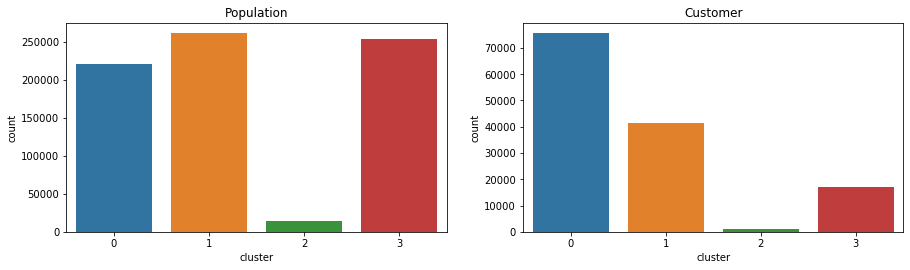

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.6)

plt.subplot(2, 2, 1)
plt.title('Population')
sns.countplot(x=population['cluster'])

plt.subplot(2, 2, 2)
plt.title('Customer')
sns.countplot(x=customer['cluster'])

plt.show()

In [55]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Relatively unpopular with the company
unpopular = pd.DataFrame(pca.inverse_transform(X[population[population['cluster'] == 2].index, :]))
unpopular.columns = df_scaled.columns

# Top 3 positive or negative features in the first componet 
unpopular[[
    'KBA13_BAUMAX',
 'KBA13_ANTG4',
 'D19_KONSUMTYP_MAX',
 'KBA05_GBZ',
 'LP_STATUS_FEIN',
 'KBA05_ANTG1'
]].head()

,KBA13_BAUMAX,KBA13_ANTG4,D19_KONSUMTYP_MAX,KBA05_GBZ,LP_STATUS_FEIN,KBA05_ANTG1
0,0.931133,1.059317,-0.074240,0.190676,0.218360,-0.059835
1,-0.091763,0.163621,0.943740,0.255201,0.166156,0.065125
2,-0.033129,0.139838,0.685786,0.559036,0.450267,0.198235
3,0.199905,0.284371,0.934577,-0.000154,0.393127,-0.062477
4,0.217807,0.445005,0.974394,-0.059367,0.335816,0.051246


In [56]:
# Relatively popular with the company
popular = pd.DataFrame(pca.inverse_transform(X[population[population['cluster'] == 0].index, :]))
popular.columns = df_scaled.columns

# Top 3 positive or negative features in the first componet 
popular[[
    'KBA13_BAUMAX',
 'KBA13_ANTG4',
 'D19_KONSUMTYP_MAX',
 'KBA05_GBZ',
 'LP_STATUS_FEIN',
 'KBA05_ANTG1'
]].head()

,KBA13_BAUMAX,KBA13_ANTG4,D19_KONSUMTYP_MAX,KBA05_GBZ,LP_STATUS_FEIN,KBA05_ANTG1
0,0.256594,0.375320,-0.076985,0.494313,0.324773,0.238037
1,0.256980,0.377578,-0.027437,0.401069,0.374616,0.206741
2,0.760335,0.992569,0.391169,0.784484,0.426917,0.604714
3,0.014528,0.049840,0.863108,0.776956,1.114676,0.670888
4,0.079940,0.251275,0.092017,0.853901,0.930008,0.667463


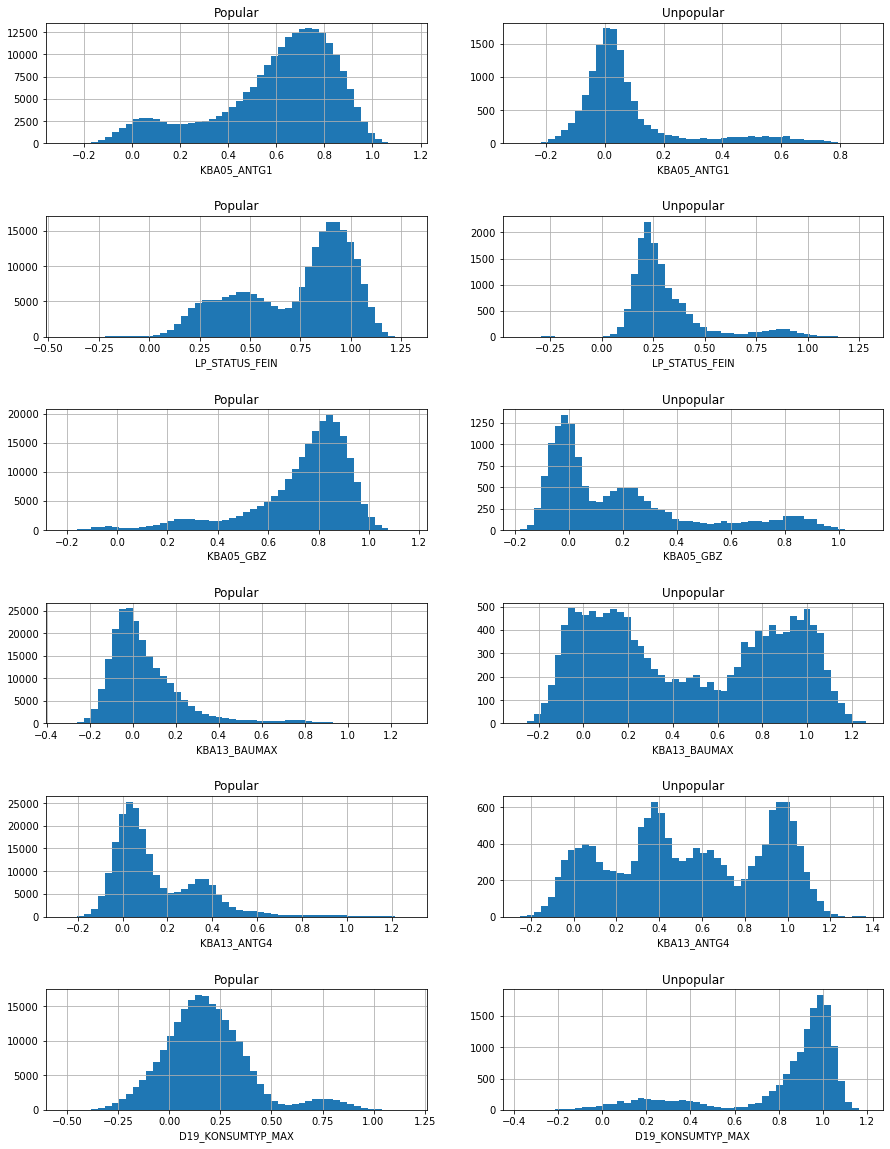

In [58]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.6)

# PLZ8_ANTG4
plt.subplot(6, 2, 1)
plt.title('Popular')
plt.xlabel('KBA05_ANTG1')
popular['KBA05_ANTG1'].hist(bins=50)
plt.subplot(6, 2, 2)
plt.title('Unpopular')
plt.xlabel('KBA05_ANTG1')
unpopular['KBA05_ANTG1'].hist(bins=50)

#  'LP_STATUS_FEIN'
plt.subplot(6, 2, 3)
plt.title('Popular')
plt.xlabel( 'LP_STATUS_FEIN')
popular[ 'LP_STATUS_FEIN'].hist(bins=50)
plt.subplot(6, 2, 4)
plt.title('Unpopular')
plt.xlabel( 'LP_STATUS_FEIN')
unpopular[ 'LP_STATUS_FEIN'].hist(bins=50)

# 'KBA05_GBZ'
plt.subplot(6, 2, 5)
plt.title('Popular')
plt.xlabel('KBA05_GBZ')
popular['KBA05_GBZ'].hist(bins=50)
plt.subplot(6, 2, 6)
plt.title('Unpopular')
plt.xlabel('KBA05_GBZ')
unpopular['KBA05_GBZ'].hist(bins=50)

# 'KBA13_BAUMAX'
plt.subplot(6, 2, 7)
plt.title('Popular')
plt.xlabel('KBA13_BAUMAX')
popular['KBA13_BAUMAX'].hist(bins=50)
plt.subplot(6, 2, 8)
plt.title('Unpopular')
plt.xlabel('KBA13_BAUMAX')
unpopular['KBA13_BAUMAX'].hist(bins=50)

# 'KBA13_ANTG4'
plt.subplot(6, 2, 9)
plt.title('Popular')
plt.xlabel('KBA13_ANTG4')
popular['KBA13_ANTG4'].hist(bins=50)
plt.subplot(6, 2, 10)
plt.title('Unpopular')
plt.xlabel('KBA13_ANTG4')
unpopular['KBA13_ANTG4'].hist(bins=50)



# 'D19_KONSUMTYP_MAX'
plt.subplot(6, 2, 11)
plt.title('Popular')
plt.xlabel('D19_KONSUMTYP_MAX')
popular['D19_KONSUMTYP_MAX'].hist(bins=50)
plt.subplot(6, 2, 12)
plt.title('Unpopular')
plt.xlabel('D19_KONSUMTYP_MAX')
unpopular['D19_KONSUMTYP_MAX'].hist(bins=50)


plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
mailout_train.shape

(42962, 367)

In [7]:
# how many postive samples are in the data set?
mailout_train["RESPONSE"].value_counts(normalize=True)

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

In [8]:
mailout_train.isna().mean()[mailout_train.isna().mean()>0.3].sort_values(ascending=False)

ALTER_KIND4     0.999046
ALTER_KIND3     0.995950
ALTER_KIND2     0.982403
ALTER_KIND1     0.953727
KK_KUNDENTYP    0.589265
EXTSEL992       0.371212
dtype: float64

In [9]:
mailout_train = mailout_train.drop(["ALTER_KIND4","ALTER_KIND3","ALTER_KIND2","ALTER_KIND1"],axis = 1)

In [10]:
for i in mailout_train.select_dtypes(include = "object").columns:
    print(i,len(set(mailout_train[i])))

CAMEO_DEU_2015 46
CAMEO_DEUG_2015 5647
CAMEO_INTL_2015 5671
D19_LETZTER_KAUF_BRANCHE 36
EINGEFUEGT_AM 1600
OST_WEST_KZ 3


In [11]:
mailout_train['CAMEO_DEUG_2015']=[-1 if i == "X" else i for i in mailout_train['CAMEO_DEUG_2015']]
mailout_train['CAMEO_INTL_2015']= [-1 if i == "XX" else i for i in mailout_train['CAMEO_INTL_2015']]

In [12]:
mailout_train["EINGEFUEGT_AM"] = mailout_train["EINGEFUEGT_AM"].astype("datetime64")
mailout_train["CAMEO_DEUG_2015"] = mailout_train["CAMEO_DEUG_2015"].astype("float64")
mailout_train["CAMEO_INTL_2015"] = mailout_train["CAMEO_INTL_2015"].astype("float64")

In [13]:
mailout_train["EINGEFUEGT_AM"] = mailout_train["EINGEFUEGT_AM"].apply(lambda x: x.year - 1991)

In [14]:
mailout_train = df_clean(mailout_train)

In [15]:
mailout_train["D19_LETZTER_KAUF_BRANCHE"] = mailout_train["D19_LETZTER_KAUF_BRANCHE"].astype("category")
mailout_train["D19_LETZTER_KAUF_BRANCHE"] = mailout_train["D19_LETZTER_KAUF_BRANCHE"].cat.codes
mailout_train["CAMEO_DEU_2015"] = mailout_train["CAMEO_DEU_2015"].astype("category")
mailout_train["CAMEO_DEU_2015"] = mailout_train["CAMEO_DEU_2015"].cat.codes

In [16]:
del mailout_train["LNR"]

In [17]:
#https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
def corr_df(x, corr_val,target):
    '''
    Obj: Drops features that are strongly correlated to other features.
        Between two highly correlated features, keep the one which is the most correlated to the target.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
          target: Target name
    Output: df that only includes uncorrelated features
    '''
    np.warnings.filterwarnings('ignore')
    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val and col.values[0] != target and row.values[0] != target :
                # Prints the correlated feature set and the corr val
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                a = x[col.values[0]].corr(x[target])
                b = x[row.values[0]].corr(x[target])
                if a < b:
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])

    drops = list(set(drop_cols))
    # Drops the correlated columns
    df = x.drop(drops, axis=1)

    return(df,drops)

In [18]:
mailout_train.shape

(42962, 365)

In [19]:
corr = corr_df(mailout_train, 0.8,"RESPONSE")
mailout_train = corr[0]

In [20]:
mailout_train.shape

(42962, 314)

In [21]:
classes = mailout_train["RESPONSE"]
del mailout_train["RESPONSE"]

In [22]:
mailout_train = mailout_train.fillna(mailout_train.mode().iloc[0])

In [23]:
x = mailout_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_scaled = pd.DataFrame(x_scaled,columns = mailout_train.columns)

explained variance ratio (first two components): [0.11705278 0.07492926]


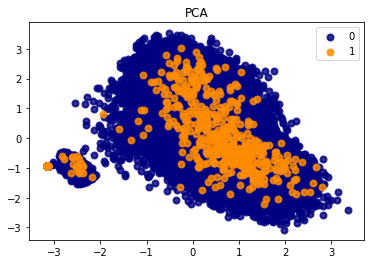

In [24]:
X = data_scaled
y = np.array(classes)
target_names = np.array([0, 1], dtype='<U10')

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)



# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy','darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')


plt.show()

In [25]:
def plot_2d_space(X, y, label='Classes'):   
    colors  = ['navy', 'darkorange']
    markers = ['o', 'o']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Using TensorFlow backend.


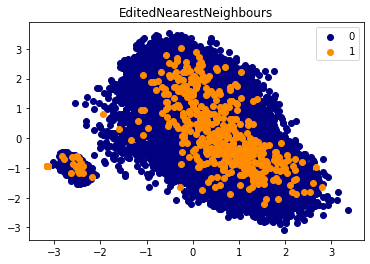

In [26]:
tl = EditedNearestNeighbours()
X_tl, y_tl = tl.fit_resample(data_scaled.values,np.array(classes))

X_tl2, y_tl2 = tl.fit_resample(X_r,np.array(classes))
plot_2d_space(X_tl2, y_tl2, 'EditedNearestNeighbours')

In [27]:
pd.value_counts(y_tl2)

0    41124
1      532
dtype: int64

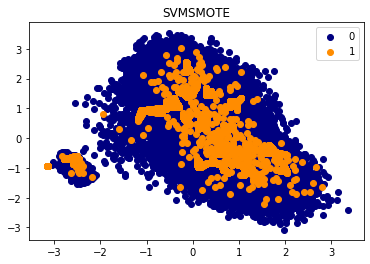

In [28]:
tl =   SVMSMOTE()
X_smote, y_smote = tl.fit_resample(X_tl,y_tl)

X_tl2, y_tl2 = tl.fit_resample(X_r,np.array(classes))
plot_2d_space(X_tl2, y_tl2, 'SVMSMOTE')

In [49]:
pd.value_counts(y_smote)

0    40830
1    17059
dtype: int64

In [78]:
df_train=pd.DataFrame(data=X_smote[0:,0:],
           index=[i for i in range(X_smote.shape[0])],
          columns=list(data_scaled.columns))

In [79]:
y_train=pd.DataFrame(data=y_smote[:],
           index=[i for i in range(y_smote.shape[0])],
          columns=['RESPONSE'])

In [70]:
y_train['RESPONSE'].value_counts(normalize = True)

0    0.705315
1    0.294685
Name: RESPONSE, dtype: float64

In [86]:
X_train, X_test, y_train, y_test = \
        train_test_split(df_train, y_train, test_size=.3, random_state=42)  

In [87]:
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None)
clf = AdaBoostClassifier(base_estimator = DTC,n_estimators=500,learning_rate = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     12287
           1       0.84      0.97      0.90      5080

    accuracy                           0.94     17367
   macro avg       0.92      0.95      0.93     17367
weighted avg       0.94      0.94      0.94     17367



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [88]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [89]:
mailout_test.shape

(42833, 366)

In [90]:
mailout_test = mailout_test.drop(["ALTER_KIND4","ALTER_KIND3","ALTER_KIND2","ALTER_KIND1"],axis = 1)
mailout_test['CAMEO_DEUG_2015']=[-1 if i == "X" else i for i in mailout_test['CAMEO_DEUG_2015']]
mailout_test['CAMEO_INTL_2015']= [-1 if i == "XX" else i for i in mailout_test['CAMEO_INTL_2015']]
mailout_test["EINGEFUEGT_AM"] = mailout_test["EINGEFUEGT_AM"].astype("datetime64")
mailout_test["CAMEO_DEUG_2015"] = mailout_test["CAMEO_DEUG_2015"].astype("float64")
mailout_test["CAMEO_INTL_2015"] = mailout_test["CAMEO_INTL_2015"].astype("float64")
mailout_test["EINGEFUEGT_AM"] = mailout_test["EINGEFUEGT_AM"].apply(lambda x: x.year - 1991)
mailout_test =df_clean(mailout_test)
mailout_test["D19_LETZTER_KAUF_BRANCHE"] = mailout_test["D19_LETZTER_KAUF_BRANCHE"].astype("category")
mailout_test["D19_LETZTER_KAUF_BRANCHE"] = mailout_test["D19_LETZTER_KAUF_BRANCHE"].cat.codes
mailout_test["CAMEO_DEU_2015"] = mailout_test["CAMEO_DEU_2015"].astype("category")
mailout_test["CAMEO_DEU_2015"] = mailout_test["CAMEO_DEU_2015"].cat.codes
mailout_test = mailout_test.drop(corr[1],axis = 1)
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHR_decade,PRAEGENDE_JUGENDJAHR_movements,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage,WOHNLAGE_rural,WOHNLAGE_neighborhood
0,1754,2,1.0,7.0,6.0,0.0,0.0,2.0,2.0,0.0,...,6.0,9.0,3,4,1,1,5.0,3,2.0,4.0
1,1770,-1,1.0,0.0,0.0,0.0,0.0,1.0,21.0,0.0,...,6.0,9.0,3,4,3,2,3.0,1,2.0,2.0
2,1465,2,9.0,16.0,11.0,0.0,0.0,4.0,2.0,0.0,...,2.0,9.0,3,4,3,1,2.0,1,2.0,3.0
3,1470,-1,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,9.0,3,4,3,2,5.0,3,2.0,5.0
4,1478,1,1.0,21.0,13.0,0.0,0.0,4.0,1.0,0.0,...,3.0,9.0,4,4,4,2,3.0,1,1.0,1.0


In [91]:
IDs = mailout_test.LNR.tolist()
test_data = mailout_test.iloc[:,1:]
mailout_test = mailout_test.fillna(mailout_test.mode().iloc[0])
x = mailout_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test_data = pd.DataFrame(x_scaled,columns = mailout_test.columns)
del test_data["LNR"]

In [92]:
pred = clf.predict(test_data)
df =pd.DataFrame(IDs,columns =["LNR"])
df["RESPONSE"] = pd.DataFrame(pred.round())
df.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [93]:
df.to_csv("Kaggle_Competition_Prediction.csv",index=False)